## Load files from the github repo

This notebook was created in google colab. We clone the repository and re-organize the folders.

In [1]:
! git clone https://github.com/ybenabed/field_road_classifier.git

Cloning into 'field_road_classifier'...
remote: Enumerating objects: 1126, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 1126 (delta 10), reused 21 (delta 6), pack-reused 1099
Receiving objects: 100% (1126/1126), 150.43 MiB | 22.94 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (1087/1087), done.


In [2]:
! mv -t . field_road_classifier/*

In [3]:
! mv data/dataset .

## Imports

In [1]:
import torch

In [2]:
from train import FieldRoadClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Train on augmented data


Initialize the field_road object. This will download the pre-trained EfficientNet model and customize its classifier.

In [ ]:
field_road = FieldRoadClassifier(prefix="aug")

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [ ]:
field_road.fit(dataset_path="dataset/augmented", VAL_TOLERANCE=1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10 Total loss: 4.885258883237839	 Validation loss: 3.5192591547966003
Epoch 2/10 Total loss: 3.8769604563713074	 Validation loss: 3.205582618713379
Epoch 3/10 Total loss: 3.971732497215271	 Validation loss: 2.8868753910064697
Epoch 4/10 Total loss: 3.898943990468979	 Validation loss: 2.0266276597976685
Epoch 5/10 Total loss: 3.901664912700653	 Validation loss: 1.8637700974941254
Epoch 6/10 Total loss: 3.8685132265090942	 Validation loss: 1.8206517100334167
Epoch 7/10 Total loss: 3.839059889316559	 Validation loss: 1.7184499204158783
Epoch 8/10 Total loss: 3.9216956198215485	 Validation loss: 1.6560820937156677
Epoch 9/10 Total loss: 3.9098560512065887	 Validation loss: 1.689458817243576
Early Stopping Triggered


Plot train and validation loss

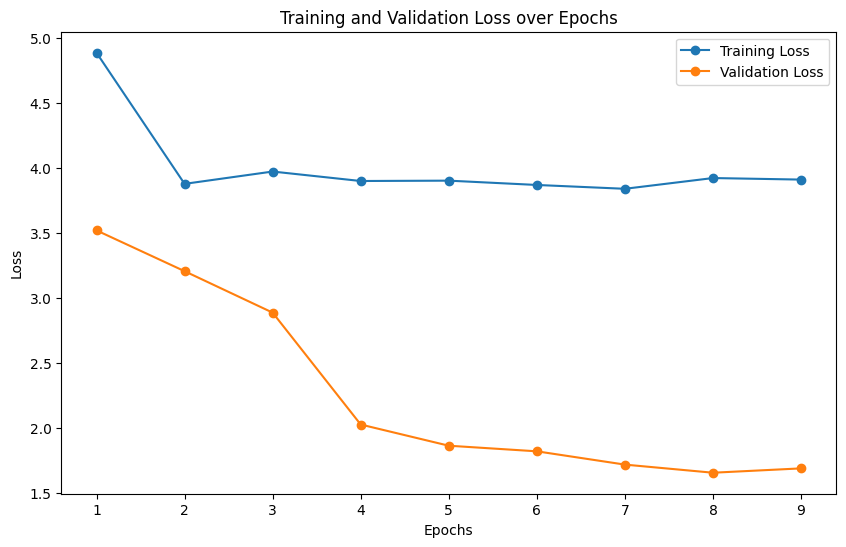

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(f"{field_road.output_folder}/metrics.csv")

train_loss = df['Total Loss']
val_loss = df['Val Loss']
epochs = df.index + 1

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')

# Adding legend
plt.legend()

# Show the plot
plt.show()

## Train on augmented data with additional 90 degree rotation


The additional 90 degree rotation has been added to have roads with more angles.

In [7]:
field_road = FieldRoadClassifier(prefix="aug_90")
field_road.fit(dataset_path="dataset/augmented_plus", VAL_TOLERANCE=2)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Epoch 1/10 Total loss: 5.756410896778107	 Validation loss: 3.3906009793281555
Epoch 2/10 Total loss: 4.834260791540146	 Validation loss: 2.171494781970978
Epoch 3/10 Total loss: 4.809052467346191	 Validation loss: 1.8421619832515717
Epoch 4/10 Total loss: 4.899461597204208	 Validation loss: 1.9378459751605988
Epoch 5/10 Total loss: 5.027396649122238	 Validation loss: 1.636004239320755
Epoch 6/10 Total loss: 4.960363686084747	 Validation loss: 2.0405766665935516
Epoch 7/10 Total loss: 5.226004868745804	 Validation loss: 2.423322916030884
Early Stopping Triggered


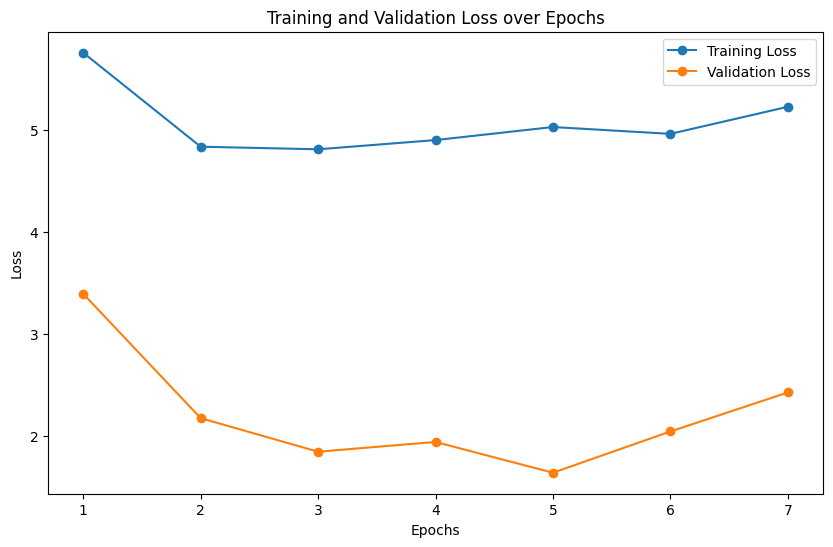

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(f"{field_road.output_folder}/metrics.csv")

train_loss = df['Total Loss']
val_loss = df['Val Loss']
epochs = df.index + 1

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')

# Adding legend
plt.legend()

# Show the plot
plt.show()

In [10]:
confusion = pd.read_csv(f"{field_road.output_folder}/confusion_matrix.csv")
confusion

,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score
0,75,3,49,23,0.961538,0.765306,0.852273


The low recall and the false negatives mean that one class is better predicted than the other.

## Weighted loss training:

In [11]:
field_road = FieldRoadClassifier(prefix="weighted_aug_90")
train_loader, val_loader, class_weights = field_road.load_data(dataset_path="dataset/augmented_plus")
field_road.model = field_road.model.to(field_road.device)
optimizer = torch.optim.Adam(field_road.model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(field_road.device)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [12]:
field_road.training(
    num_epochs=10,
    VAL_TOLERANCE=2,
    train_loader=train_loader,
    val_loader=val_loader,
    model=field_road.model,
    optimizer=optimizer,
    criterion=criterion,
)

Epoch 1/10 Total loss: 6.1437592804431915	 Validation loss: 2.4715400338172913
Epoch 2/10 Total loss: 4.922728091478348	 Validation loss: 1.978170394897461
Epoch 3/10 Total loss: 4.976508349180222	 Validation loss: 1.8023426234722137
Epoch 4/10 Total loss: 4.908381879329681	 Validation loss: 1.9222991466522217
Epoch 5/10 Total loss: 4.9737548828125	 Validation loss: 1.7431906163692474
Epoch 6/10 Total loss: 4.929430276155472	 Validation loss: 1.956643432378769
Epoch 7/10 Total loss: 4.993376821279526	 Validation loss: 1.9981066286563873
Early Stopping Triggered


In [13]:
confusion = pd.read_csv(f"{field_road.output_folder}/confusion_matrix.csv")
confusion

,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score
0,93,2,41,14,0.978947,0.869159,0.920792


### With AdaGrad optimizer

The Adagrad optimizer, featuring an adaptive learning rate, is adopted after noting in the previous configurations using Adam that the loss becomes less consistent as it approaches smaller values.


In [14]:
field_road = FieldRoadClassifier(prefix="weighted_aug_90")
train_loader, val_loader, class_weights = field_road.load_data(dataset_path="dataset/augmented_plus")
field_road.model = field_road.model.to(field_road.device)
optimizer = torch.optim.Adagrad(field_road.model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(field_road.device)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [15]:
field_road.training(
    num_epochs=10,
    VAL_TOLERANCE=2,
    train_loader=train_loader,
    val_loader=val_loader,
    model=field_road.model,
    optimizer=optimizer,
    criterion=criterion,
)

Epoch 1/10 Total loss: 6.345997661352158	 Validation loss: 2.48671418428421
Epoch 2/10 Total loss: 4.82363748550415	 Validation loss: 2.1493407785892487
Epoch 3/10 Total loss: 4.7333455085754395	 Validation loss: 1.9472993910312653
Epoch 4/10 Total loss: 4.723894506692886	 Validation loss: 1.8189710974693298
Epoch 5/10 Total loss: 4.721074223518372	 Validation loss: 1.7115340530872345
Epoch 6/10 Total loss: 4.712287575006485	 Validation loss: 1.6906785070896149
Epoch 7/10 Total loss: 4.707938015460968	 Validation loss: 1.6639806926250458
Epoch 8/10 Total loss: 4.710127264261246	 Validation loss: 1.6450015902519226
Epoch 9/10 Total loss: 4.707897573709488	 Validation loss: 1.63215771317482
Epoch 10/10 Total loss: 4.71310618519783	 Validation loss: 1.603254109621048


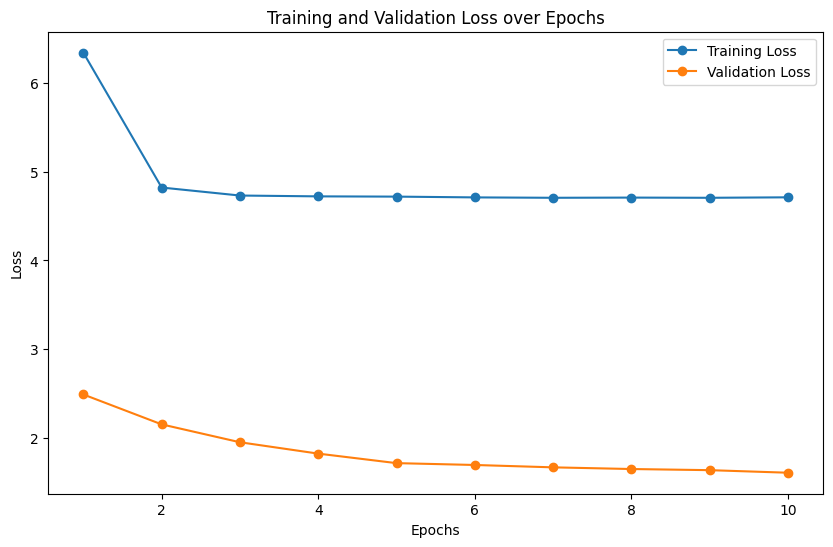

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(f"{field_road.output_folder}/metrics.csv")

train_loss = df['Total Loss']
val_loss = df['Val Loss']
epochs = df.index + 1

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')

# Adding legend
plt.legend()

# Show the plot
plt.show()

In [16]:
confusion = pd.read_csv(f"{field_road.output_folder}/confusion_matrix.csv")
confusion

,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score
0,109,0,40,1,1.0,0.990909,0.995434


In [25]:
field_road.output_folder

'outputs/weighted_aug_90_19122023:0115'

## Prediction on test images

In [21]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [22]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Grayscale(num_output_channels=3)
])

test_dataset = datasets.ImageFolder(root="dataset/test", transform=transform)



test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
field_road.model.eval()
test_labels = []
test_outs = []
for inputs, labels in test_loader:
  test_labels.extend(labels)
  inputs, labels = inputs.to("cuda"), labels.to("cuda")
  # Forward pass
  outputs = field_road.model(inputs)
  test_outs.extend(outputs.cpu().argmax(axis=1))

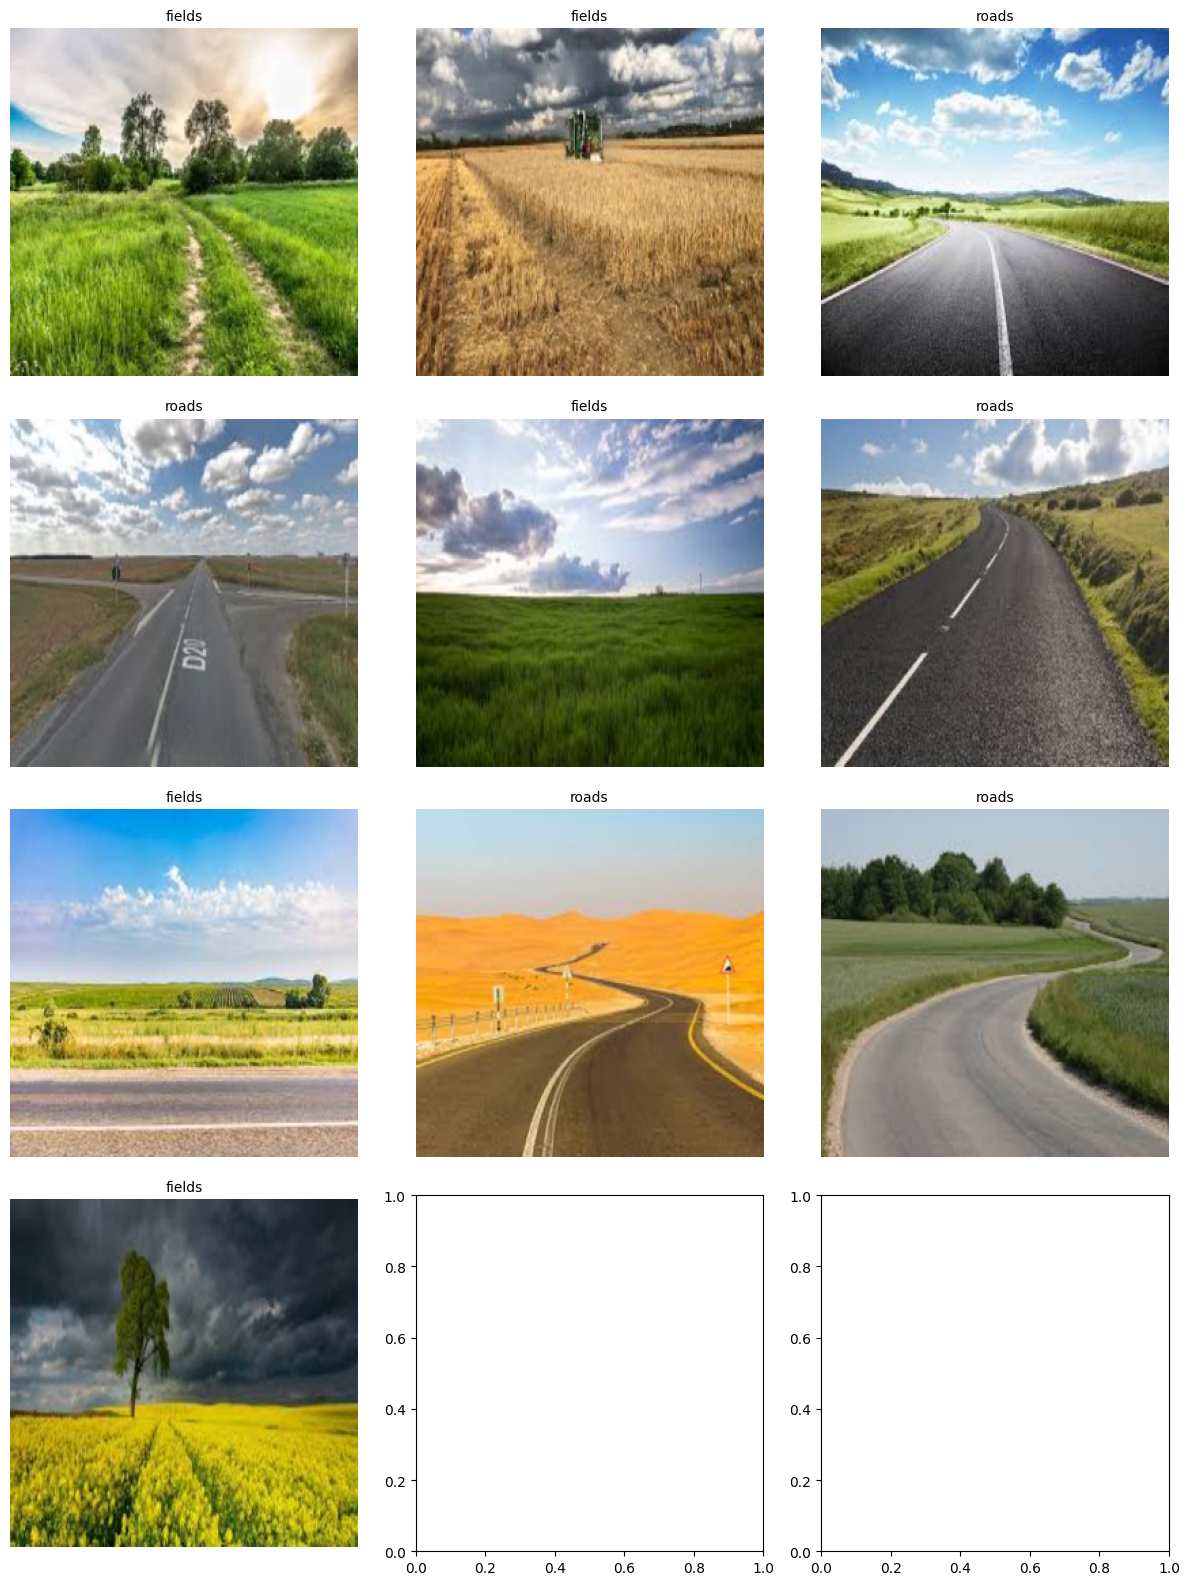

In [24]:
import matplotlib.pyplot as plt
import random


# Create a 4x3 subplot grid
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

axes = axes.flatten()

for i in range(10):
    img_idx = i
    tuple_idx = 0

    # Plot the image
    axes[i].imshow(test_dataset[img_idx][tuple_idx].permute(1, 2, 0))
    axes[i].set_title(field_road.class_labels[test_outs[img_idx]], fontsize=10)

    # Turn off the axes for better visibility
    axes[i].axis('off')

# Adjust layout to prevent clipping of images
plt.tight_layout()
plt.show()